# Spectrally Incoherent Array

Another notebook in the series of analysis of Mark's trap array design. 

This notebook explores the effect of Gaussian array generation with polychromatic fields. 

In [13]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from simfuncs import * # for saving/retreiving data
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

def lorentzian(x, x0, Gamma):
    """Lorentzian function of x, w/ mean x0 and FWHM Gamma"""
    return (1/pi)*(Gamma/2)/((x-x0)**2+(Gamma/2)**2)

images saved in ..\images


## Monochromatic dark trap array

Sanity check before polychromatic field propagation

b=0.002516, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000045, zTalboty=0.000045
f - z2 = 0.0
calculated field2 in 0.7220699787139893 s
f - z2 = 0.0
calculated field2 in 0.8456511497497559 s
f - z2 = -4.482424242424274e-05
calculated field2 in 0.868715763092041 s


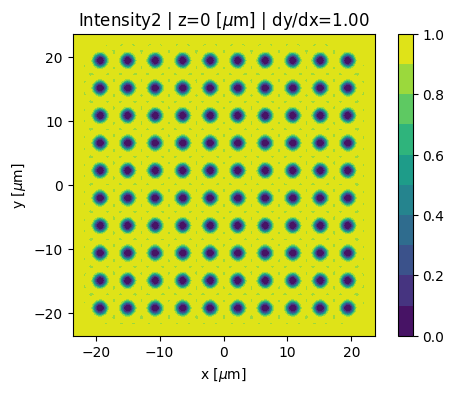

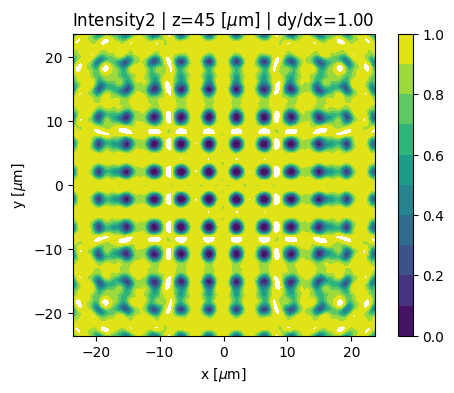

In [4]:
# single component propagation sanity check
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 0.5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask params
r1 = 0.50 # reflectivity of the spots for dark traps. if not applicable, just set to 1. trust me.
r2 = 1 # dual grid has fully transmitting spots

a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum = ynum = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

# build the mask -- backplate and partially transmitting spots
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding = pts//2 # int(3*pts/2) #TODO set
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False,padval=1)

# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
padding = pts//2 #int(3*pts/2)

zvals = [f2, f2 + zTalbotx]

for z2 in zvals: 
    
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True)

    I2_xy = conjugate(field2)*field2
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy = I2_xy/I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m]'
    title += f' | dy/dx={dy/dx:0.2f}' #Uniform input $\phi$
    # title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)

## Polychromatic dark trap array
Simulate propagation of a polychromatic field through array generator.

$E(\rho_1,z_1) = \sum_j E_j(\rho_1,z_1) \exp(-i(\omega_j t + k_j z + \phi_j)))$ where I dropped the positive frequency component

Then the field having gone through Fresnel diffraction to plane z2 is

$E(z2) = \frac{1}{2\pi z_2}\sum_j \exp(-(i \omega_j t  + k_j z + \phi_j)) \mathcal{F}[E_j(\rho_1,z_1) \exp(k\rho_1^2/z_1)]$

showing that the resultant field should just be the sum of the Fresnel diffracted field components 

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
Power spectrum FWHM: 13878.75 GHz
Coherence length: 0.000022


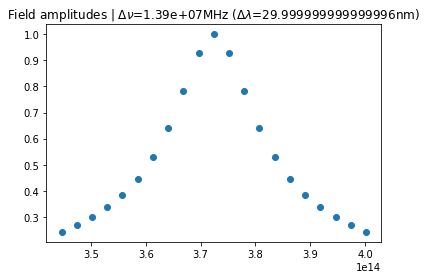

In [2]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
dlmbda = 30e-9 # FWHM
nu0 = c/lmbda
dnu = dlmbda*nu0**2/c # FWHM of freq. spectrum

# lorentzian scaled to have peak value = 1
L = lambda nu: lorentzian(nu, nu0, dnu)/lorentzian(nu0,nu0,dnu)
k = 2*pi/lmbda

f1 = 0.5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask params
r1 = 0.50 # reflectivity of the spots for dark traps. if not applicable, just set to 1. trust me.
r2 = 1 # dual grid has fully transmitting spots

a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum = ynum = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
print(f'Power spectrum FWHM: {dnu/1e9:0.2f} GHz')
print(f'Coherence length: {c/dnu:0.6f}')

"""Discretize the Lorentzian power spectral density lineshape function, 
and then use the sqrt amplitude of each PSD amplitude as the field 
amplitude. We don't know any phase information so just pick a random phase 
from a flat distribution. """

# generate frequency components

halfwidth = 2*dnu # the abs value of the spectral domain to sample
components=21
nu_pts = linspace(nu0-halfwidth,nu0+halfwidth,components)
nu_pts.sort()

plt.title(rf"Field amplitudes | $\Delta \nu$={dnu/1e6:0.3}MHz ($\Delta \lambda$={dlmbda*1e9}nm)")
plt.scatter(nu_pts, sqrt(L(nu_pts)))

In [1]:
# build the mask -- backplate and partially transmitting spots
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)
focal_field = np.zeros(mask.shape,complex)
talbot_field = np.zeros(mask.shape,complex)

# focal_int = np.zeros(mask.shape)
# talbot_int = np.zeros(mask.shape)

# iterate over frequency components
for i,nu in enumerate(nu_pts):
    
    k = 2*pi*nu/c # wave number

    # input field 
    field0 = mask*sqrt(L(nu))*exp(-1j*2*pi*rand())

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2 #int(3*pts/2)

    zvals = [f2, f2 + zTalbotx]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)
        
        if z2 == f2:
            focal_field += field2
        else:
            talbot_field += field2
            
    print(f"step {i} completed")

NameError: name 'spot_mask' is not defined

saved file to ..\images\plot_polychrm_13878MHz_whitephi_z2_0um_21pts_10x10.png
saved file to ..\images\plot_polychrm_13878MHz_whitephi_z2_45um_21pts_10x10.png


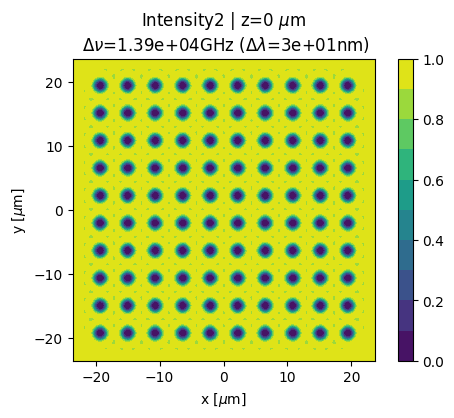

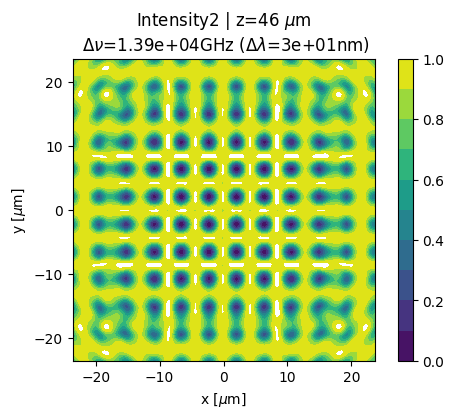

In [7]:
# plot field in focal and talbot planes and save

savefig = True
for output_field,z2 in zip([focal_field,talbot_field],zvals):
    I2_xy = conjugate(output_field)*output_field
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} $\mu$m'
    title += '\n'+rf' $\Delta \nu$={dnu/1e9:0.3}GHz ($\Delta \lambda$={dlmbda*1e9:0.0}nm)' #Uniform input $\phi$
    # title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)
    
    if savefig:
        fname = os.path.join(imagedir, 
            f'plot_polychrm_{int(dnu/1e9)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_{components}pts_{xnum}x{ynum}.png')
        plt.savefig(fname, bbox_inches='tight')
        print(f"saved file to {fname}")
savefig = False

saved file to ..\images\plot_polychrm_13878745MHz_whitephi_z2_45um_xzslices_21pts_10x10.png


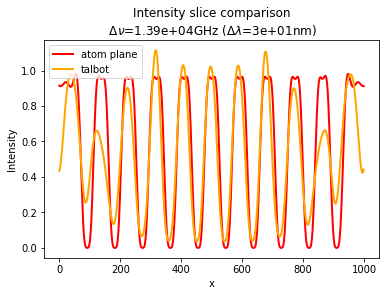

In [8]:
savefig=True
fig, ax = plt.subplots()
ax.set_title(rf'Intensity slice comparison' 
             +'\n'+rf' $\Delta \nu$={dnu/1e9:0.3}GHz ($\Delta \lambda$={dlmbda*1e9:0.0}nm)')
ax.set_xlabel("x")
ax.set_ylabel("Intensity")
I2xy_max = 1
for field,label,color,lw in zip([field0,focal_field,talbot_field],['input','atom plane','talbot'],['teal','red','orange'],['1','2','2']):
    # because of the ordering of labels/fields, the talbot plane is scaled to the atom plane
    
    I2_xy = real(conjugate(field)*field)
    if label == 'atom plane':
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    if label != 'input':
        ax.plot(range(pts), I2_xy[450,:],lw=lw,label=label,c=color)
    
ax.legend(loc='upper left')
if savefig:
    fname = os.path.join(imagedir, 
        f'plot_polychrm_{int(dnu/1e6)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_xzslices_{components}pts_{xnum}x{ynum}.png')
    plt.savefig(fname, bbox_inches='tight')
    print(f"saved file to {fname}")
    savefig=False

## Spectral and spatial incoherence

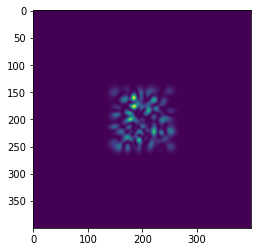

In [3]:
# multimode field test from spatially_incoherent notebook

# Make a spatially multi-mode laser field
w0 = 1
hw = 10*w0
pts = 400
xarr, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 10

field = multimode_field(nrange,w0,hw,pts)
I2xy = real(field*conjugate(field))
I2xy /= amax(I2xy)
fig,ax = plt.subplots()
ax.imshow(I2xy)

In [15]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
dlmbda = 4e-9 # FWHM
nu0 = c/lmbda
dnu = dlmbda*nu0**2/c # FWHM of freq. spectrum

# lorentzian scaled to have peak value = 1
L = lambda nu: lorentzian(nu, nu0, dnu)/lorentzian(nu0,nu0,dnu)
k = 2*pi/lmbda

f1 = 0.5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum = ynum = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
print(f'Power spectrum FWHM: {dnu/1e9:0.2f} GHz')
print(f'Coherence length: {c/dnu:0.6f}')

"""Discretize the Lorentzian power spectral density lineshape function, 
and then use the sqrt amplitude of each PSD amplitude as the field 
amplitude. We don't know any phase information so just pick a random phase 
from a flat distribution. """

# generate frequency components

halfwidth = 2*dnu # the abs value of the spectral domain to sample
components=21
nu_pts = linspace(nu0-halfwidth,nu0+halfwidth,components)
nu_pts.sort()

# plt.title(rf"Field amplitudes | $\Delta \nu$={dnu/1e6:0.3}MHz ($\Delta \lambda$={dlmbda*1e9}nm)")
# plt.scatter(nu_pts, sqrt(L(nu_pts)))

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
Power spectrum FWHM: 1850.50 GHz
Coherence length: 0.000162


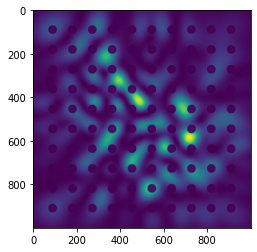

In [8]:
# test input field

pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 1 # plate transmissivity

field0, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

nrange = 10 # Hermite-Gaussian modes go from A_{0,0} up to A_{nrange,nrange}
w0 = w/3

mmode_field = multimode_field(nrange,w0,w,pts)
field0 *= mmode_field

plt.imshow(real(field0*conjugate(field0)))

In [16]:
# build the mask -- backplate and partially transmitting spots
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = 1/sqrt(1.998) # aperture reflectivity
t_plate = 1 # plate transmissivity

multimode = True
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)
# focal_field = np.zeros(mask.shape,complex)
# talbot_field = np.zeros(mask.shape,complex)
focal_int = np.zeros(mask.shape)
talbot_int = np.zeros(mask.shape)
# number of modes and size of embedded Gaussian beam. for now my heuristic is to have the number of modes not exceed
# order ~ 1000, and to pick the waist of the fundamental mode to give a beam of the desired size
nrange = 10 # Hermite-Gaussian modes go from A_{0,0} up to A_{nrange,nrange}
w0 = w/3

# iterate over frequency components
for i,nu in enumerate(nu_pts):
    
    k = 2*pi*nu/c # wave number

    # input field
    field0 = mask*sqrt(L(nu))
    if multimode:
        mmode_field = multimode_field(nrange,w0,w,pts)
        field0 *= mmode_field

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2 #int(3*pts/2)

    zvals = [f2, f2 + zTalbotx]

    for z2 in zvals:

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)
        
        if z2 == f2:
#             focal_field += field2 #
            focal_int += real(conjugate(field2)*field2)
            
        else:
#             talbot_field += field2
            talbot_int += real(conjugate(field2)*field2)
            
    print(f"step {i} completed")

step 0 completed
step 1 completed
step 2 completed
step 3 completed
step 4 completed
step 5 completed
step 6 completed
step 7 completed
step 8 completed
step 9 completed
step 10 completed
step 11 completed
step 12 completed
step 13 completed
step 14 completed
step 15 completed
step 16 completed
step 17 completed
step 18 completed
step 19 completed
step 20 completed


wrote data to .\paper_data\spatial_spectral_incoh_focus_1625945900.csv
wrote data to .\paper_data\spatial_spectral_incoh_talbot_1625945902.csv


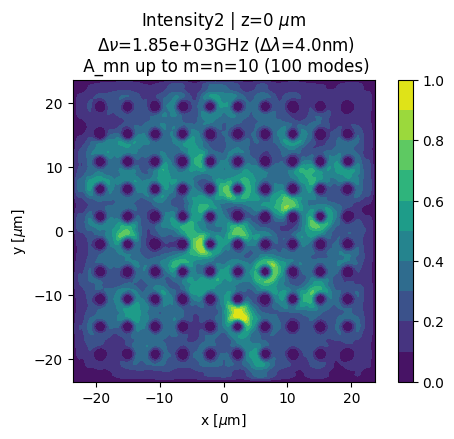

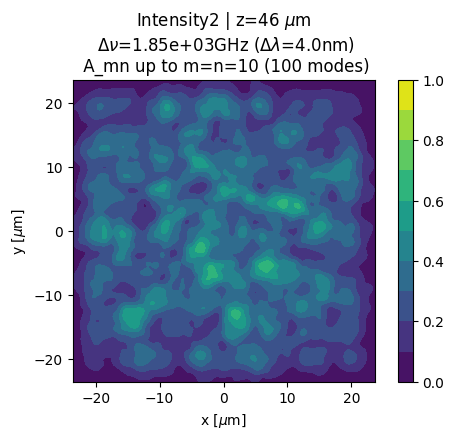

In [17]:
# plot field in focal and talbot planes and save

savefig = False
savedata = True

# imagedir = os.path.join('..','images')
imagedir = os.path.join('.','paper_data')
name = 'spatial_spectral_incoh'


metadata=f"lambda={lmbda}, nu_pts={nu_pts}, dnu={dnu}, dlmbda={dlmbda}, H.G. modes nmax=mmax={nrange},\
        embedded Gaussian w0={w0}, f1={f1}, f2={f2}, \
        xnum={xnum}, ynum={ynum}, a1={a}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        r1={r_aper}, t1={t_plate}, a2={None}, r2={None}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"

labels = ['focus','talbot']
# for l,output_field,z2 in zip(labels[focal_field,talbot_field],zvals):
#     I2_xy = conjugate(output_field)*output_field # output_field #
for l,output_int,z2 in zip(labels,[focal_int,talbot_int],zvals):
    I2_xy = output_int
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} $\mu$m'
    title += '\n'+rf' $\Delta \nu$={dnu/1e9:0.3}GHz ($\Delta \lambda$={dlmbda*1e9}nm)' #Uniform input $\phi$
    if multimode:
        title += f'\n A_mn up to m=n={nrange} ({nrange**2} modes)'
    # title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)
    
    if savedata:
            fname = f'{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
    
    if savefig:
        if multimode:
            fname = os.path.join(imagedir, 
                f'plot_polychrm_{int(dnu/1e9)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_{components}pts_spatial{nrange**2}modes_{xnum}x{ynum}.png')
        else:
            fname = os.path.join(imagedir, 
                f'plot_polychrm_{int(dnu/1e9)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_{components}pts_{xnum}x{ynum}.png')
        plt.savefig(fname, bbox_inches='tight')
        print(f"saved file to {fname}")
savefig = False

saved file to ..\images\plot_polychrm_9252496MHz_whitephi_z2_45um_xzslices_21pts_10x10.png


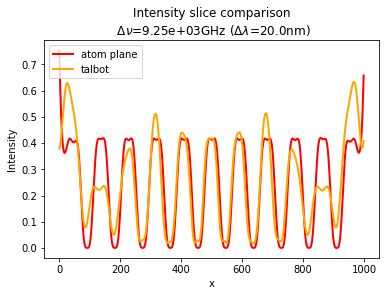

In [16]:
savefig=True
fig, ax = plt.subplots()
ax.set_title(rf'Intensity slice comparison' 
             +'\n'+rf' $\Delta \nu$={dnu/1e9:0.3}GHz ($\Delta \lambda$={dlmbda*1e9}nm)')
ax.set_xlabel("x")
ax.set_ylabel("Intensity")
I2xy_max = 1
for intensity,label,color,lw in zip([abs(field0)**2,focal_int,talbot_int],['input','atom plane','talbot'],['teal','red','orange'],['1','2','2']):
    # because of the ordering of labels/fields, the talbot plane is scaled to the atom plane
    
    I2_xy = intensity #real(conjugate(field)*field)
    if label == 'atom_plane':
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    if label != 'input':
        ax.plot(range(pts), I2_xy[450,:],lw=lw,label=label,c=color)
    
ax.legend(loc='upper left')
if savefig:
    if multimode:
        fname = os.path.join(imagedir, 
            f'plot_polychrm_{int(dnu/1e6)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_xzslices_{components}pts_spatial{nrange**2}modes_{xnum}x{ynum}.png')
    else:
        fname = os.path.join(imagedir, 
                f'plot_polychrm_{int(dnu/1e6)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_xzslices_{components}pts_{xnum}x{ynum}.png')
    plt.savefig(fname, bbox_inches='tight')
    print(f"saved file to {fname}")
    savefig=False

## misc testing

In [66]:
# properly compute the intensity from a sum of fields with random phases

field = 0
num = 1000
for i in range(num):
    E0 = 1
    field += E0*exp(-1j*2*pi*rand())
    
field*conjugate(field), field

((416.6015260999049+0j), (19.047056999569016+7.335608069892632j))

Text(0.5, 0, '$\\Delta \\lambda$ [nm]')

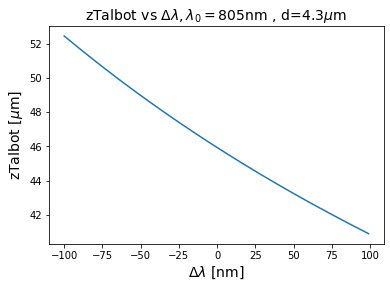

In [110]:
# talbot plane location vs lambda

dnm_pts = range(-100,100)
d = 4.3
plt.plot(dnm_pts, [2*d**2/((805+nm)*1e-3) for nm in dnm_pts])
plt.title('zTalbot vs $\Delta\lambda, \lambda_0=805$nm , d=4.3$\mu$m',fontsize=14)
plt.ylabel("zTalbot [$\mu$m]",fontsize=14)
plt.xlabel("$\Delta \lambda$ [nm]",fontsize=14)